In [3]:
import pandas as pd
import scipy.odr.odrpack as odrpack
import math
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from statsmodels.tsa.stattools import adfuller as adf

In [5]:
def f(B, x):
    return B[0]*x + B[1]

def cal_PnL(X, Y, slope, intercept, standevi, open, close, stoploss, tag, amount):
    residual = []
    for i in range(len(X)):
        residual.append(Y[i] - slope * X[i] - intercept)

    signal = 0
    entry_time = []
    exit_time = []
    trade_style = []
    success_num = 0
    trade_day = 0
    return_list = []
    for i in range(len(X)):
        if signal == 0:
            return_list.append(0)
            if Y[i] - slope * X[i] - intercept >= open * standevi:
                signal = 1
            if Y[i] - slope * X[i] - intercept <= -open * standevi:
                signal = -1
        else:
            if signal == 1:
                return_list.append(0)
                if (Y[i] - slope * X[i] - intercept <= open * standevi) and (Y[i] - slope * X[i] - intercept >= close * standevi):
                    signal = 2
                    entry_time.append(i)
            else:
                if signal == -1:
                    return_list.append(0)
                    if (Y[i] - slope * X[i] - intercept >= -open * standevi) and (Y[i] - slope * X[i] - intercept <= -close * standevi):
                        signal = -2
                        entry_time.append(i)
                else:
                    if signal == 2:
                        trade_day = trade_day + 1
                        return_list.append((residual[i - 1] - residual[i]) / (1 + abs(slope)))
                        if Y[i] - slope * X[i] - intercept <= close * standevi:
                            signal = 0
                            exit_time.append(i)
                            trade_style.append('positive')
                            success_num = success_num + 1
                        else:
                            if Y[i] - slope * X[i] - intercept >= stoploss * standevi:
                                signal = 0
                                exit_time.append(i)
                                trade_style.append('stoploss_positive')
                    else:
                        if signal == -2:
                            return_list.append((residual[i] - residual[i - 1]) / (1 + abs(slope)))
                            trade_day = trade_day + 1
                            if Y[i] - slope * X[i] - intercept >= -close * standevi:
                                signal = 0
                                exit_time.append(i)
                                trade_style.append('negative')
                                success_num = success_num + 1
                            else:
                                if Y[i] - slope * X[i] - intercept <= -stoploss * standevi:
                                    signal = 0
                                    exit_time.append(i)
                                    trade_style.append('stoploss_negative')

    if signal == 2:
        exit_time.append(i)
        trade_style.append('positive')

    if signal == -2:
        exit_time.append(i)
        trade_style.append('negative')


    # print(entry_time)
    Num_of_Trade1 = len(entry_time)
    if Num_of_Trade1 == 0:
        success_rate1 = 0
    else:
        success_rate1 = success_num / Num_of_Trade1
    trade_frequency1 = trade_day / len(X)

    Sharpe_Ratio1 = (np.mean(return_list) - 0.03 / 252 / 24 / 4) / np.std(return_list)
    Sharpe_Ratio1 = Sharpe_Ratio1 * 4 * 24 * 12


    entry_residual = []
    for i in entry_time:
        entry_residual.append(residual[i])
    # print(exit_time)
    exit_residual = []
    for i in exit_time:
        exit_residual.append(residual[i])
    # print(trade_style)

    if tag == 1:

        # plot the hit map
        plt.figure()
        plt.plot(range(len(residual)), residual, 'k')
        ax = plt.axes()
        x = np.linspace(1, len(residual)+1, 1000)
        ax.plot(x, [0] * len(x), 'k')
        ax.plot(x, [open * standevi] * len(x), 'b', label='open: {}_std'.format(str(open)))
        ax.plot(x, [-open * standevi] * len(x), 'b', label='open: {}_std'.format(str(-open)))
        ax.plot(x, [close * standevi] * len(x), 'c', label='close: {}_std'.format(str(close)))
        ax.plot(x, [-close * standevi] * len(x), 'c', label='close: {}_std'.format(str(-close)))
        ax.plot(x, [stoploss * standevi] * len(x), 'r', label='stoploss: {}_std'.format(str(stoploss)))
        ax.plot(x, [-stoploss * standevi] * len(x), 'r', label='stoploss: {}_std'.format(str(-stoploss)))

        plt.plot(entry_time, entry_residual, 'go')
        plt.plot(exit_time, exit_residual, 'ro')
        plt.title('Hit map')
        plt.xlabel('15-mins')
        plt.ylabel('residual')
        plt.legend(loc='best', fontsize='large')
        plt.show()

    total_PnL = 0
    test_winner_PnL = 0
    test_loser_PnL = 0
    for i in range(len(entry_time)):
        if 'stoploss_positive' == trade_style[i]:
            test_loser_PnL = test_loser_PnL + (entry_residual[i] - exit_residual[i]) * amount / (1 + abs(slope))
            total_PnL = total_PnL + (entry_residual[i] - exit_residual[i]) * amount / abs(Y[i] + slope * X[i])
        if 'stoploss_negative' == trade_style[i]:
            test_loser_PnL = test_loser_PnL + (exit_residual[i] - entry_residual[i]) * amount / (1 + abs(slope))
            total_PnL = total_PnL + (exit_residual[i] - entry_residual[i]) * amount / abs(Y[i] + slope * X[i])
        if 'positive' == trade_style[i]:
            test_winner_PnL = test_winner_PnL + (entry_residual[i] - exit_residual[i]) * amount / (1 + abs(slope))
            total_PnL = total_PnL + (entry_residual[i] - exit_residual[i]) * amount / abs(Y[i] + slope * X[i])
        if 'negative' == trade_style[i]:
            test_winner_PnL = test_winner_PnL + (exit_residual[i] - entry_residual[i]) * amount / (1 + abs(slope))
            total_PnL = total_PnL + (exit_residual[i] - entry_residual[i]) * amount / abs(Y[i] + slope * X[i])

    # print(total_PnL)
    Return1 = total_PnL / amount

    return total_PnL, success_rate1, Num_of_Trade1, trade_frequency1, Return1, Sharpe_Ratio1, test_winner_PnL, test_loser_PnL



ARNC/PNR
324.40699604586655 1 0 2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


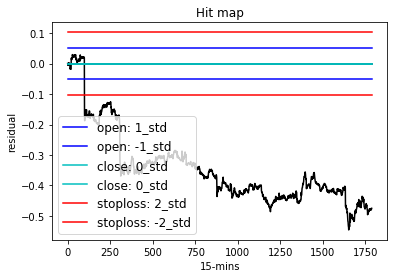

0 0 0 0.0 0.0 -inf
HII/PNR
332.32078833699 1 -0.2 3


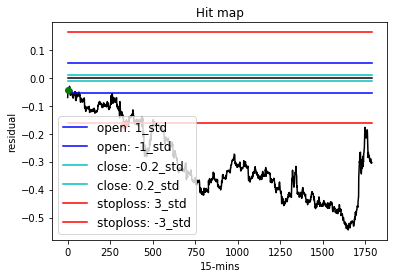

-65.24053911024599 0.0 1 0.18288590604026847 -0.006524053911024599 -29.158379581612152
RE/SIVB
759.2269079298712 1.5 -0.2 4


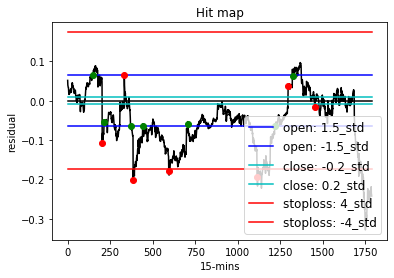

98.14392279730811 0.5714285714285714 7 0.5335570469798657 0.009814392279730811 7.385993455382982
EXPE/KMX
460.9070998365021 1.5 -0.1 3


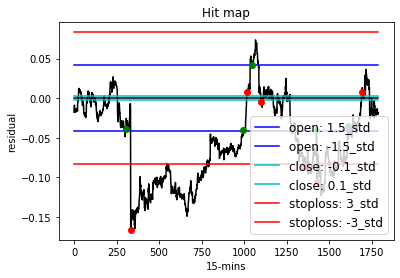

-86.74009468137314 0.5 6 0.14373601789709173 -0.008674009468137314 -17.202153228714828
BSX/WCG
301.84845285413905 1 -0.1 3


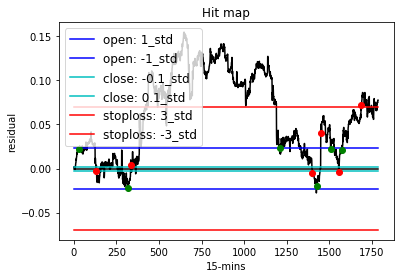

110.17068850627919 0.8333333333333334 6 0.27293064876957496 0.011017068850627918 35.152330309457966
HCA/ILMN
233.41200909688064 1 -0.2 4


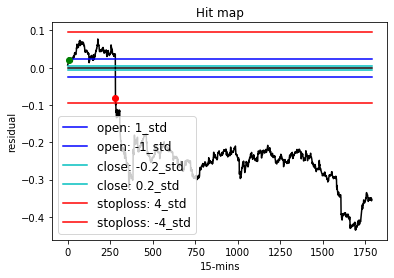

69.67662879298905 1.0 1 0.15212527964205816 0.006967662879298905 19.679391972760627
BSX/NKTR
1637.9806291153975 1 0.2 3


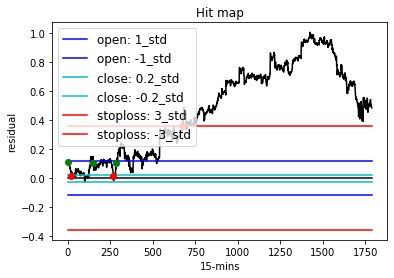

-57.52400021740792 0.6666666666666666 3 0.2930648769574944 -0.005752400021740792 -6.869219460054304
EXPE/NKE
477.19531235241817 1.5 -0.2 3


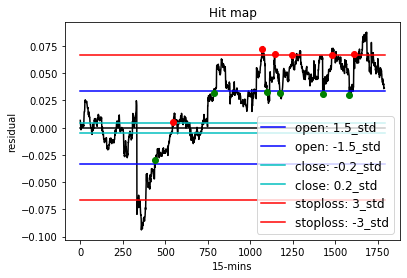

-164.4093310043438 0.16666666666666666 6 0.3243847874720358 -0.01644093310043438 -54.509949316070205
KMX/NKE
296.80671629733064 3 -0.2 4


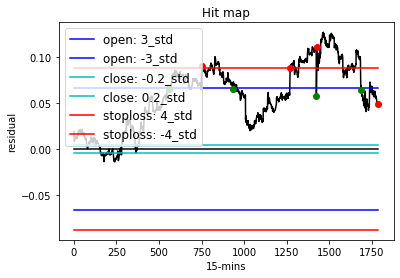

-122.39800478972587 0.0 4 0.35626398210290827 -0.012239800478972588 -31.86835535976428
KMX/MAT
666.5418934767494 1 -0.2 3


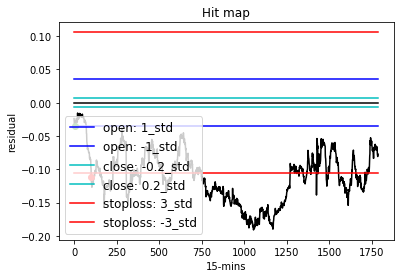

-93.48591342116131 0.0 1 0.05425055928411633 -0.009348591342116132 -64.98917766897291
          InSample_PnL         PnL  success_rate  Num_of_Trade  \
ARNC/PNR    324.406996    0.000000      0.000000             0   
HII/PNR     332.320788  -65.240539      0.000000             1   
RE/SIVB     759.226908   98.143923      0.571429             7   
EXPE/KMX    460.907100  -86.740095      0.500000             6   
BSX/WCG     301.848453  110.170689      0.833333             6   
HCA/ILMN    233.412009   69.676629      1.000000             1   
BSX/NKTR   1637.980629  -57.524000      0.666667             3   
EXPE/NKE    477.195312 -164.409331      0.166667             6   
KMX/NKE     296.806716 -122.398005      0.000000             4   
KMX/MAT     666.541893  -93.485913      0.000000             1   

          trade_frequency    Return  Sharpe_Ratio   winner_PnL    loser_PnL  
ARNC/PNR         0.000000  0.000000          -inf     0.000000     0.000000  
HII/PNR          0.182886 -0.00

In [6]:
df = pd.read_csv("15_min_clean.csv")
nan_list = []
for i in range(1, len(df.columns)):
    price_list = list(df.iloc[:, i])
    for j in reversed(range(len(price_list))):
        if math.isnan(price_list[j]):
            break
    nan_list.append(j)

threshold = len(df) * 0.3

columns = ['Date']
max_num = -1
for i in range(1, len(df.columns)):
    name = df.columns[i]
    if nan_list[i-1] < threshold:
        if nan_list[i-1] > max_num:
            max_num = nan_list[i-1]
        columns.append(name)

df = df.loc[:, columns]

if max_num > -1:
    df = df.drop(range(max_num + 1))

columns = []
for name in df.columns:
    columns.append(name.split(' ')[0])

df.columns = columns
df.index = range(len(df))

stock_list = df.columns
stock_list = stock_list[1::]
log_stock_list = []

# Calculate log price

for stock in stock_list:
    log_stock_list.append('log_' + stock)
    df['log_' + stock] = df[stock].apply(lambda x: math.log(x))

log_df = df.loc[:, ['Date'] + log_stock_list]
log_df.columns = columns

# split the data into training data and test data
training_df = log_df.loc[range(int(len(log_df) * 1 / 2)), :]
test_df = log_df.loc[range(int(len(log_df) * 1 / 2), len(log_df)), :]


Top_pairs = [('ARNC/PNR', -5.715842375679389), ('HII/PNR', -4.684261878900894), ('RE/SIVB', -4.664145560574728), ('EXPE/KMX', -4.48282873421785),
             ('BSX/WCG', -4.468561516267557), ('HCA/ILMN', -4.283825976073916), ('BSX/NKTR', -4.225664480120963), ('EXPE/NKE', -4.101408914378844),
             ('KMX/NKE', -4.099116098048863), ('KMX/MAT', -4.067419723961796)]

pairs_list = []
for pairs, test_value in Top_pairs:
    pairs_list.append(pairs)


info_columns1 = ['PnL', 'success_rate', 'Num_of_Trade', 'trade_frequency', 'Return', 'Sharpe_Ratio', 'winner_PnL', 'loser_PnL']
result_df = pd.DataFrame(np.arange(len(pairs_list) * len(['InSample_PnL'] + info_columns1)).reshape(len(pairs_list), len(['InSample_PnL'] + info_columns1)), index=pairs_list, columns=['InSample_PnL'] + info_columns1)
re_df = pd.DataFrame(np.arange(len(pairs_list) * len(['InSample_PnL'] + info_columns1)).reshape(len(pairs_list), len(['InSample_PnL'] + info_columns1)), index=pairs_list, columns=['InSample_PnL'] + info_columns1)
info_columns = ['open', 'close', 'stoploss', 'PnL', 'success_rate', 'Num_of_Trade', 'trade_frequency', 'Return', 'Sharpe_Ratio', 'winner_PnL', 'loser_PnL']


for pairs, test_value in Top_pairs:
    print(pairs)
    # if pairs != 'BSX/WCG':
    #     continue
    stock1 = pairs.split('/')[0]
    stock2 = pairs.split('/')[1]

    X = list(training_df.loc[:, stock1])
    Y = list(training_df.loc[:, stock2])

    # Use TLS to determine the hedge ratio
    linear = odrpack.Model(f)
    mydata = odrpack.RealData(X, Y)
    myodr = odrpack.ODR(mydata, linear, beta0=[1., 2.])
    myoutput = myodr.run()

    intercept = myoutput.beta[1]
    slope = myoutput.beta[0]

    residual = []
    for i in range(len(X)):
        residual.append(Y[i] - slope * X[i] - intercept)
    standevi = np.std(residual)

    open_level = [1, 1.5, 2.0, 2.5, 3]
    # open_level = [1.5, 2.0, 2.5, 3]
    close_level = [-0.2, -0.1, 0, 0.1, 0.2]
    # close_level = [0, 0.1, 0.2]
    # stoploss_level = [4]
    stoploss_level = [2, 3, 4, 5, 6]

    optimal_open = 0
    optimal_stoploss = 0
    optimal_close = 0
    max_PnL = 0
    info_df = pd.DataFrame(np.arange(len(open_level) * len(close_level) * len(stoploss_level) *
                                     len(info_columns)).reshape(len(open_level) * len(close_level) * len(stoploss_level), len(info_columns)),
                           index=range(len(open_level) * len(close_level) * len(stoploss_level)), columns=info_columns)
    num = 0
    for open in open_level:
        for close in close_level:
            for stoploss in stoploss_level:
                PnL, success_rate, Num_of_Trade, trade_frequency, Return, Sharpe_Ratio, winner_PnL, loser_PnL = cal_PnL(X, Y, slope, intercept, standevi, open, close, stoploss, 0, 10000)
                info_df.loc[num, 'open'] = open
                info_df.loc[num, 'close'] = close
                info_df.loc[num, 'stoploss'] = stoploss
                info_df.loc[num, 'PnL'] = PnL
                info_df.loc[num, 'success_rate'] = success_rate
                info_df.loc[num, 'Num_of_Trade'] = Num_of_Trade
                info_df.loc[num, 'trade_frequency'] = trade_frequency
                info_df.loc[num, 'Return'] = Return
                info_df.loc[num, 'Sharpe_Ratio'] = Sharpe_Ratio
                info_df.loc[num, 'winner_PnL'] = winner_PnL
                info_df.loc[num, 'loser_PnL'] = loser_PnL
                num = num + 1
                if PnL > max_PnL:
                    max_PnL = PnL
                    optimal_open = open
                    optimal_stoploss = stoploss
                    optimal_close = close

    # info_df.to_csv("C:\\Users\\zy108\\Desktop\\Statistical arbitrage\\project\\info_df.csv", index=False)


    print(max_PnL, optimal_open, optimal_close, optimal_stoploss)

    X1 = list(test_df.loc[:, stock1])
    Y1 = list(test_df.loc[:, stock2])
    test_PnL, test_success_rate, test_Num_of_Trade, test_trade_frequency, test_Return, test_Sharpe_Ratio, test_winner_PnL, test_loser_PnL = \
        cal_PnL(X1, Y1, slope, intercept, standevi, optimal_open, optimal_close, optimal_stoploss, 1, 10000)
    print(test_PnL, test_success_rate, test_Num_of_Trade, test_trade_frequency, test_Return, test_Sharpe_Ratio)
    result_df.loc[pairs, 'InSample_PnL'] = max_PnL
    result_df.loc[pairs, 'PnL'] = test_PnL
    result_df.loc[pairs, 'success_rate'] = test_success_rate
    result_df.loc[pairs, 'Num_of_Trade'] = test_Num_of_Trade
    result_df.loc[pairs, 'trade_frequency'] = test_trade_frequency
    result_df.loc[pairs, 'Return'] = test_Return
    result_df.loc[pairs, 'Sharpe_Ratio'] = test_Sharpe_Ratio
    result_df.loc[pairs, 'winner_PnL'] = test_winner_PnL
    result_df.loc[pairs, 'loser_PnL'] = test_loser_PnL

print(result_df)

result_df.to_csv("result_df.csv")






In [7]:
tot=-29.15+7.385+-17.202153+35.15+19.679-6.869+-54.509-31.86-64.98

In [8]:
tot

-142.356153